<a href="https://colab.research.google.com/github/vinodnbhat/AIML_CEP_2021/blob/main/Sentiment_Analysis_TA_session_Dec_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will work with the IMDB dataset, which contains movie reviews from IMDB. Each review is labeled as 1 (for positive) or 0 (for negative) from the rating provided by users together with their reviews.\
This dataset is available [here](https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format/download).


Code referred from [here](https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch/notebook)

#Importing Libraries and Data

In [ ]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
## upload data files to this colab notebook and read them using the respective paths

df_train = pd.read_csv('/content/Train.csv')
df_val = pd.read_csv('/content/Valid.csv')
df_test = pd.read_csv('/content/Test.csv')
df_train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
x_train, y_train = df_train['text'].values, df_train['label'].values
x_val, y_val = df_val['text'].values, df_val['label'].values
x_test, y_test = df_test['text'].values, df_test['label'].values
print(f'shape of train data is {x_train.shape}')
print(f'shape of val data is {x_val.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (40000,)
shape of val data is (5000,)
shape of test data is (5000,)


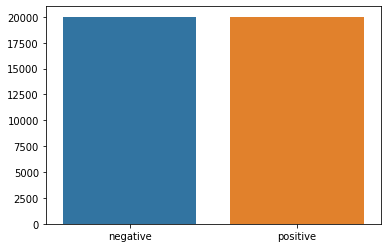

In [ ]:
#plot of positive and negative class count in training set
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

#Pre-Processing Data

In [ ]:
def preprocess_string(s):
  """ preprocessing string to remove special characters, white spaces and digits """
  s = re.sub(r"[^\w\s]", '', s) # Remove all non-word characters (everything except numbers and letters)
  s = re.sub(r"\s+", '', s) # Replace all runs of whitespaces with no space
  s = re.sub(r"\d", '', s) # replace digits with no space
  return s

def create_corpus(x_train):
  """ creates dictionary of 1000 most frequent words in the training set and assigns token number to the words, returns dictionay (named corpus)"""
  word_list = []
  stop_words = set(stopwords.words('english')) 
  for sent in x_train:
      for word in sent.lower().split():
          word = preprocess_string(word)
          if word not in stop_words and word != '':
              word_list.append(word)

  word_count = Counter(word_list)
  # sorting on the basis of most common words
  top_words = sorted(word_count, key=word_count.get, reverse=True)[:1000]
  # creating a dict
  corpus = {w:i+1 for i,w in enumerate(top_words)}
  return corpus

def preprocess(x, y, corpus):
  """ encodes reviews according to created corpus dictionary"""
  x_new = []
  for sent in x:
    x_new.append([corpus[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in corpus.keys()])

  return np.array(x_new), np.array(y)

In [ ]:
corpus = create_corpus(x_train)
print(f'Length of vocabulary is {len(corpus)}')
x_train, y_train = preprocess(x_train, y_train, corpus)
x_val, y_val = preprocess(x_val, y_val, corpus)
x_test, y_test = preprocess(x_test, y_test, corpus)

Length of vocabulary is 1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


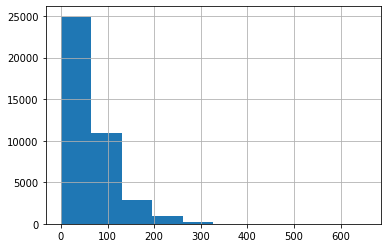

count    40000.000000
mean        69.295200
std         48.098095
min          0.000000
25%         39.000000
50%         54.000000
75%         85.000000
max        653.000000
dtype: float64

In [ ]:
#analysis of word count in reviews 
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

From the above data, it can be seen that maximum length of review is 653 and 75% of the reviews have length less than 85. Furthermore length of reviews greater than 300 is not significant (from the graph) so will take maximum length of reviews to be 300.

In [ ]:
def padding_(sentences, seq_len):
  """ to tackle variable length of sequences: this function prepads reviews with 0 for reviews whose length is less than seq_len, and truncates reviews with length greater than
  seq_len by removing words after seq_len in review"""

  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, review in enumerate(sentences):
    diff = seq_len - len(review)

    if diff > 0:
      features[ii,diff:] = np.array(review)

    else:
      features[ii] = np.array(review[:seq_len])

  return features

In [ ]:
# maximum review length (300)
x_train_pad = padding_(x_train,300)
x_val_pad = padding_(x_val,300)
x_test_pad = padding_(x_test, 300)

In [ ]:
is_cuda = torch.cuda.is_available()

# use GPU if available
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

batch_size = 50

# dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
# one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) 
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 300])
Sample input: 
 tensor([[  0,   0,   0,  ..., 572,   1,   1],
        [  0,   0,   0,  ...,  38, 457,  87],
        [  0,   0,   0,  ..., 168, 841, 253],
        ...,
        [  0,   0,   0,  ..., 171,   5, 225],
        [  0,   0,   0,  ...,   9, 446,   2],
        [  0,   0,   0,  ..., 917, 179,  95]])
Sample output: 
 tensor([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1])


<img src="https://lh3.googleusercontent.com/proxy/JeOqyqJyqifJLvX8Wet6hHNIOZ_wui2xfIkYJsK6fuE13cNJlZxxqe6vZcEe__kIagkOFolHZtyZ150yayUHpBkekTAwdMUg1MNrmVFbd1eumvusUs1zLALKLB5AA3fK" alt="RNN LSTM GRU" width="700" height="250">

Image Credit- [Article](http://dprogrammer.org/rnn-lstm-gru)

#RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,output_dim):
      super(RNN,self).__init__()

      self.output_dim = output_dim
      self.hidden_dim = hidden_dim

      self.no_layers = no_layers
      self.vocab_size = vocab_size

      self.embedding = nn.Embedding(vocab_size, embedding_dim)

      self.rnn = nn.RNN(input_size=embedding_dim,hidden_size=self.hidden_dim,
                          num_layers=no_layers, batch_first=True)
      
      self.dropout = nn.Dropout(0.3)
      self.fc = nn.Linear(self.hidden_dim, output_dim)
      self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
      batch_size = x.size(0)
      embeds = self.embedding(x)  
      rnn_out, hidden = self.rnn(embeds, hidden)
      rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)
      out = self.dropout(rnn_out)
      out = self.fc(out)
      sig_out = self.sig(out)
      sig_out = sig_out.view(batch_size, -1)
      sig_out = sig_out[:, -1] 
      return sig_out, hidden
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        return h0

In [ ]:
no_layers = 2
vocab_size = len(corpus) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

In [ ]:
model = RNN(no_layers,vocab_size,hidden_dim,embedding_dim,output_dim)
model.to(device)
print(model)

RNN(
  (embedding): Embedding(1001, 64)
  (rnn): RNN(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
lr=0.001 #learning rate
criterion = nn.BCELoss() #Binary Cross Entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

def acc(pred,label):
  """ function to calculate accuracy """
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

In [ ]:
patience_early_stopping = 3  #training will stop if model performance does not improve for these many consecutive epochs
cnt = 0 #counter for checking patience level
prev_epoch_acc = 0.0 #initializing prev test accuracy for early stopping condition
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.2, patience = 1) 

epochs = 10

for epoch in range(epochs):
    train_acc = 0.0
    model.train()
    
    for inputs, labels in train_loader: #training in batches
        
        inputs, labels = inputs.to(device), labels.to(device)   
        h = model.init_hidden(batch_size) 
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
     
        accuracy = acc(output,labels)
        train_acc += accuracy
        
        optimizer.step()
 
    
    val_acc = 0.0
    model.eval()
    
    for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_h = model.init_hidden(batch_size)
            output, val_h = model(inputs, val_h)
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    scheduler.step(epoch_val_acc)

    if epoch_val_acc > prev_epoch_acc: #check if val accuracy for current epoch has improved compared to previous epoch
      cnt = 0                    #f accuracy improves reset counter to 0
    else:                        #otherwise increment current counter
      cnt += 1
    prev_epoch_acc = epoch_val_acc

    print(f'Epoch {epoch+1}') 
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

    if cnt == patience_early_stopping:
      print(f"early stopping as test accuracy did not improve for {patience_early_stopping} consecutive epochs")
      break

Epoch 1
train_accuracy : 52.980000000000004 val_accuracy : 50.160000000000004
Epoch 2
train_accuracy : 53.63250000000001 val_accuracy : 50.18
Epoch 3
train_accuracy : 62.480000000000004 val_accuracy : 75.12
Epoch 4
train_accuracy : 70.565 val_accuracy : 75.14
Epoch 5
train_accuracy : 71.33500000000001 val_accuracy : 65.52
Epoch 6
train_accuracy : 73.4475 val_accuracy : 69.26
Epoch 7
train_accuracy : 76.96 val_accuracy : 78.58000000000001
Epoch 8
train_accuracy : 74.6225 val_accuracy : 78.16
Epoch 9
train_accuracy : 76.14999999999999 val_accuracy : 66.22
Epoch 10
train_accuracy : 67.0575 val_accuracy : 70.94


In [ ]:
def predict_text(text):
        word_seq = np.array([corpus[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in corpus.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,300))
        input = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        #h = tuple([each.data for each in h])
        output, h = model(input, h)
        return(output.item())

In [ ]:
index = 30
print(df_test['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df_test["label"][index]}')
print('='*70)
prob = predict_text(df_test['text'][index])
status = "positive" if prob > 0.5 else "negative"
prob = (1 - prob) if status == "negative" else prob
print(f'Predicted sentiment is {status} with a probability of {prob}')

This movie is good for entertainment purposes, but it is not historically reliable. If you are looking for a movie and thinking to yourself `Oh I want to learn more about Custer's life and his last stand', do not rent `They Died with Their Boots On'. But, if you would like to watch a movie for the enjoyment of an older western film, with a little bit of romance and just for a good story, this is a fun movie to watch.<br /><br />The story starts out with Custer's (Errol Flynn) first day at West Point. Everyone loves his charming personality which allows him to get away with most everything. The movie follows his career from West Point and his many battles, including his battle in the Civil War. The movie ends with his last stand at Little Big Horn. In between the battle scenes, he finds love and marriage with Libby (Olivia De Havilland).<br /><br />Errol Flynn portrays the arrogant, but suave George Armstrong Custer well. Olivia De Havilland plays the cute, sweet Libby very well, especi

#GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim):
      super(GRU,self).__init__()

      self.output_dim = output_dim
      self.hidden_dim = hidden_dim
      self.no_layers = no_layers
      self.vocab_size = vocab_size
      self.embedding = nn.Embedding(vocab_size, embedding_dim)
      self.gru = nn.GRU(input_size=embedding_dim,hidden_size=self.hidden_dim,
                          num_layers=no_layers, batch_first=True)
      self.dropout = nn.Dropout(0.3)
      self.fc = nn.Linear(self.hidden_dim, output_dim)
      self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
      batch_size = x.size(0)
      embeds = self.embedding(x)  
      gru_out, hidden = self.gru(embeds, hidden)
      gru_out = gru_out.contiguous().view(-1, self.hidden_dim) 

      out = self.dropout(gru_out)
      out = self.fc(out)
      sig_out = self.sig(out)
      sig_out = sig_out.view(batch_size, -1)
      sig_out = sig_out[:, -1] 
      return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
      ''' Initializes hidden state '''
      h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
      return h0

In [ ]:
no_layers = 2
vocab_size = len(corpus) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
model = GRU(no_layers,vocab_size,hidden_dim,embedding_dim)

#moving to gpu
model.to(device)

print(model)

GRU(
  (embedding): Embedding(1001, 64)
  (gru): GRU(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to calculate accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
patience_early_stopping = 3  #training will stop if model performance does not improve for these many consecutive epochs
cnt = 0 #counter for checking patience level
prev_epoch_acc = 0.0 #initializing prev test accuracy for early stopping condition
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.2, patience = 1) 

epochs = 10

for epoch in range(epochs):
    train_acc = 0.0
    model.train()
    
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        h = model.init_hidden(batch_size)
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
     
        accuracy = acc(output,labels)
        train_acc += accuracy
        
        optimizer.step()
 
    
    val_acc = 0.0
    model.eval()
    
    for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_h = model.init_hidden(batch_size)
            output, val_h = model(inputs, val_h)
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    scheduler.step(epoch_val_acc)

    if epoch_val_acc > prev_epoch_acc: #check if val accuracy for current epoch has improved compared to previous epoch
      cnt = 0                    #f accuracy improves reset counter to 0
    else:                        #otherwise increment current counter
      cnt += 1
    prev_epoch_acc = epoch_val_acc

    print(f'Epoch {epoch+1}') 
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

    if cnt == patience_early_stopping:
      print(f"early stopping as test accuracy did not improve for {patience_early_stopping} consecutive epochs")
      break


Epoch 1
train_accuracy : 77.125 val_accuracy : 83.08
Epoch 2
train_accuracy : 85.845 val_accuracy : 85.32
Epoch 3
train_accuracy : 87.9075 val_accuracy : 85.66
Epoch 4
train_accuracy : 89.92750000000001 val_accuracy : 85.64
Epoch 5
train_accuracy : 93.13 val_accuracy : 84.89999999999999
Epoch 6
train_accuracy : 98.02499999999999 val_accuracy : 84.78
early stopping as test accuracy did not improve for 3 consecutive epochs


In [ ]:
index = 30
print(df_test['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df_test["label"][index]}')
print('='*70)
prob = predict_text(df_test['text'][index])
status = "positive" if prob > 0.5 else "negative"
prob = (1 - prob) if status == "negative" else prob
print(f'Predicted sentiment is {status} with a probability of {prob}')

This movie is good for entertainment purposes, but it is not historically reliable. If you are looking for a movie and thinking to yourself `Oh I want to learn more about Custer's life and his last stand', do not rent `They Died with Their Boots On'. But, if you would like to watch a movie for the enjoyment of an older western film, with a little bit of romance and just for a good story, this is a fun movie to watch.<br /><br />The story starts out with Custer's (Errol Flynn) first day at West Point. Everyone loves his charming personality which allows him to get away with most everything. The movie follows his career from West Point and his many battles, including his battle in the Civil War. The movie ends with his last stand at Little Big Horn. In between the battle scenes, he finds love and marriage with Libby (Olivia De Havilland).<br /><br />Errol Flynn portrays the arrogant, but suave George Armstrong Custer well. Olivia De Havilland plays the cute, sweet Libby very well, especi

#LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim):
      super(LSTM,self).__init__()

      self.output_dim = output_dim
      self.hidden_dim = hidden_dim

      self.no_layers = no_layers
      self.vocab_size = vocab_size
  
      self.embedding = nn.Embedding(vocab_size, embedding_dim) #embedding layer
      
      self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                          num_layers=no_layers, batch_first=True)  #lstm layer
      
      self.dropout = nn.Dropout(0.3)  # dropout layer
      self.fc = nn.Linear(self.hidden_dim, output_dim) #fully connected layer
      self.sig = nn.Sigmoid() #sigmoid activation 
        
    def forward(self,x,hidden):
      batch_size = x.size(0)
      embeds = self.embedding(x)  
      lstm_out, hidden = self.lstm(embeds, hidden)  
      lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
      out = self.dropout(lstm_out)
      out = self.fc(out)
      sig_out = self.sig(out)
      sig_out = sig_out.view(batch_size, -1)
      sig_out = sig_out[:, -1] 
      return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
      ''' Initializes hidden state and cell state for LSTM '''
      h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
      c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
      hidden = (h0,c0)
      return hidden

In [ ]:
no_layers = 2
vocab_size = len(corpus) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

In [ ]:
model = LSTM(no_layers,vocab_size,hidden_dim,embedding_dim)
model.to(device)
print(model)

LSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to calculate accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
patience_early_stopping = 3  #training will stop if model performance does not improve for these many consecutive epochs
cnt = 0 #counter for checking patience level
prev_epoch_acc = 0.0 #initializing prev test accuracy for early stopping condition
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.2, patience = 1) 

epochs = 10

for epoch in range(epochs):
  train_acc = 0.0
  model.train()
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)  
    h = model.init_hidden(batch_size)
    model.zero_grad()
    output,h = model(inputs,h)
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    accuracy = acc(output,labels)
    train_acc += accuracy
    optimizer.step()
  
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:
    val_h = model.init_hidden(batch_size)
    inputs, labels = inputs.to(device), labels.to(device)
    output, val_h = model(inputs, val_h)
    accuracy = acc(output,labels)
    val_acc += accuracy
          
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  scheduler.step(epoch_val_acc)

  if epoch_val_acc > prev_epoch_acc: #check if val accuracy for current epoch has improved compared to previous epoch
    cnt = 0                    #f accuracy improves reset counter to 0
  else:                        #otherwise increment current counter
    cnt += 1
  prev_epoch_acc = epoch_val_acc

  print(f'Epoch {epoch+1}') 
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if cnt == patience_early_stopping:
    print(f"early stopping as test accuracy did not improve for {patience_early_stopping} consecutive epochs")
    break

Epoch 1
train_accuracy : 74.3825 val_accuracy : 80.17999999999999
Epoch 2
train_accuracy : 83.9875 val_accuracy : 85.68
Epoch 3
train_accuracy : 86.575 val_accuracy : 85.9
Epoch 4
train_accuracy : 87.9575 val_accuracy : 85.46000000000001
Epoch 5
train_accuracy : 89.64750000000001 val_accuracy : 86.26
Epoch 6
train_accuracy : 91.8325 val_accuracy : 84.36
Epoch 7
train_accuracy : 94.6375 val_accuracy : 85.16
Epoch 8
train_accuracy : 98.3175 val_accuracy : 85.14
Epoch 9
train_accuracy : 99.4225 val_accuracy : 85.16
Epoch 10
train_accuracy : 99.815 val_accuracy : 85.0


In [ ]:
index = 30
print(df_test['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df_test["label"][index]}')
print('='*70)
prob = predict_text(df_test['text'][index])
status = "positive" if prob > 0.5 else "negative"
prob = (1 - prob) if status == "negative" else prob
print(f'Predicted sentiment is {status} with a probability of {prob}')

This movie is good for entertainment purposes, but it is not historically reliable. If you are looking for a movie and thinking to yourself `Oh I want to learn more about Custer's life and his last stand', do not rent `They Died with Their Boots On'. But, if you would like to watch a movie for the enjoyment of an older western film, with a little bit of romance and just for a good story, this is a fun movie to watch.<br /><br />The story starts out with Custer's (Errol Flynn) first day at West Point. Everyone loves his charming personality which allows him to get away with most everything. The movie follows his career from West Point and his many battles, including his battle in the Civil War. The movie ends with his last stand at Little Big Horn. In between the battle scenes, he finds love and marriage with Libby (Olivia De Havilland).<br /><br />Errol Flynn portrays the arrogant, but suave George Armstrong Custer well. Olivia De Havilland plays the cute, sweet Libby very well, especi